In [23]:
import  cv2
import matplotlib
from gamtools import segregation, matrix
import os
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import EngFormatter

# from mirnylib.numutils import removeDiagonals, observedOverExpected, fillDiagonal, PCA
from scipy.stats import pearsonr
import warnings
import cooler
import scipy


In [24]:
def pca_with_imputation(matrix):
    # 使用列的均值来填充NaN值
    imputer = SimpleImputer(strategy='mean')
    matrix_imputed = imputer.fit_transform(matrix)

    # 创建PCA对象，设置提取一个主成分
    pca = PCA(n_components=1)
    pca.fit(matrix_imputed)

    # 转换数据并提取第一主成分
    pc1 = pca.transform(matrix_imputed)[:, 0]

    return pc1

    
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)
        

def plot_matrix(matrix,title,region_start,region_end,cmap,vmax,vmin):
    plt.figure(figsize=(4,4), facecolor='white')
    plt.imshow(matrix,
               extent=(region_start, region_end, region_end, region_start),
               interpolation='none', vmin=vmin, vmax=vmax, cmap=cmap)

    plt.title(title)
    ax = plt.gca()

    ax.yaxis.set_ticks_position('left')   # 设置y轴刻度仅在左侧显示
    ax.xaxis.set_ticks_position('bottom') # 设置x轴刻度仅在底部显
    format_ticks(ax)
    #show colorbar
    cbar = plt.colorbar()
    cbar.set_label(title)
    cbar.set_ticks([vmin,0,vmax])
    cbar.set_ticklabels([vmin,0,vmax])
    #设置cbar大小

bin table

In [4]:
ref = "mm9"
df_mm = pd.read_csv(f"ref_data/{ref}.chrom.sizes",sep="\t",header=None)
df_mm.columns = ['chrom','size']
df_mm = df_mm.query("chrom!='chrX' and chrom != 'chrY'")
resolution = 40000
bins = []

# 遍历每个染色体，生成对应的bins
for index, row in df_mm.iterrows():
    chrom = row['chrom']
    size = row['size']
    for start in range(0, size, resolution):
        stop = min(start + resolution, size)
        pos = (start + stop) // 2
        bins.append([chrom, start, stop, pos])

# 将bins列表转换为DataFrame
bin_table_df = pd.DataFrame(bins, columns=['chrom', 'start', 'stop', 'pos'])
chr_list = list(bin_table_df['chrom'].unique())

In [26]:
import pickle

# 从pickle文件读取数据
with open('ref_data/mm9_gc_40kb.pickle', 'rb') as f:
    gcdic = pickle.load(f)

In [27]:
print(len(gcdic['chr1']))

4930


### GAM

In [8]:

gam_dprime_list = {}
gam_dprime_list_1m = {}
for chr in ['chr1']:
    print(chr)
    gam_path = '/share/home/mliu/shareb/mliu/HiMulti/data/multiplex_GAM/dprime_matrix/combined_segregation_at_40kb.chr1_dprime.txt.gz'
    gam_dprime_chr = pd.read_csv(gam_path,compression='gzip',sep='\t',header=0,index_col=0).values
    gam_dprime_list[chr] = gam_dprime_chr
    gam_dprime_chr_1m = cv2.resize(gam_dprime_chr, (len(gcdic[chr]), len(gcdic[chr])), interpolation=cv2.INTER_AREA)
    gam_dprime_list_1m[chr] = gam_dprime_chr_1m
    

chr1


### Hi-C


In [9]:
#load hic data
metadata = pd.read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0728/stat/stat_0728.csv")
cellnames1 = metadata[metadata['cellname'].str.startswith('d0')].query("`20k` < 1.5 & cellname != 'd0C3' & cellname != 'd0C5'")['cellname'].values

import pickle
with open('mESC2_cellname.pkl', 'rb') as file:
    cellnames2 = pickle.load(file)
print(len(cellnames2))

192


In [10]:
mesc1_path = "/shareb/mliu/HiMulti/data/mESC/mcool"
mesc2_path = "/shareb/mliu/HiMulti/data/mESC2/cooler"
mesc2_mm9_path = "/shareb/mliu/HiMulti/data/mESC2/mm9/mcool"
surfix1="balanced.mcool"
surfix2 = "mcool"
surfix2_mm9 = "mm9.mcool"


cellnames = cellnames2
mesc_path = mesc2_mm9_path
surfix = surfix2_mm9

#初始化字典
hic_list = {}
hic_list_1m = {}
clr_40k = cooler.Cooler(f"{mesc_path}/{cellnames[0]}.{surfix}::/resolutions/40000")
for chr in ['chr1']:
    region = f"{chr}(mat)"
    mat_40k = clr_40k.matrix(balance=False).fetch(region)
    mat_40k = np.zeros((mat_40k.shape[0],mat_40k.shape[0]))
    for cellname in cellnames:
        if os.path.exists(f"{mesc_path}/{cellname}.{surfix}"):
            clr=cooler.Cooler(f"{mesc_path}/{cellname}.{surfix}::/resolutions/40000")
            mat_40k += clr.matrix(balance=False).fetch(region)
    hic_list[chr] = mat_40k
    mat_40k_1m = cv2.resize(mat_40k, (len(gcdic[chr]), len(gcdic[chr])), interpolation=cv2.INTER_AREA)
    hic_list_1m[chr] = mat_40k_1m

### in silico

In [11]:

silico_dprime_list = {}
silico_dprime_list_1m = {}
for chr in ['chr1']:
    print(chr)
    silico_matrix_chr_whole = np.load(f"silico_dprime/mm9/ESC2_40kb_120_2.5_{chr}_dprime.npy")
    silico_dprime_list[chr] = silico_matrix_chr_whole
    silico_matrix_chr_whole_1m = cv2.resize(silico_matrix_chr_whole, (len(gcdic[chr]), len(gcdic[chr])), interpolation=cv2.INTER_AREA)
    silico_dprime_list_1m[chr] = silico_matrix_chr_whole_1m
    

chr1


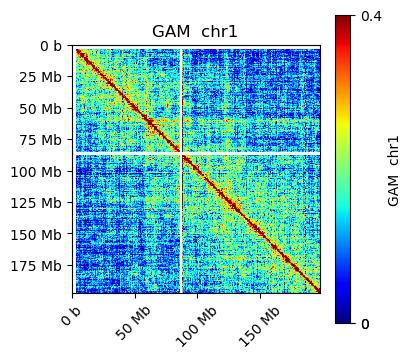

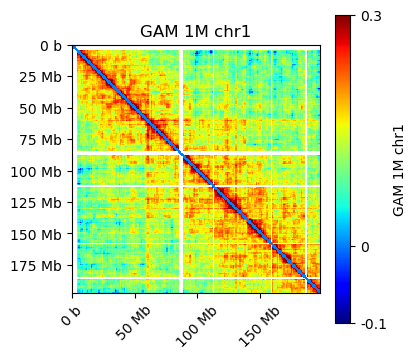

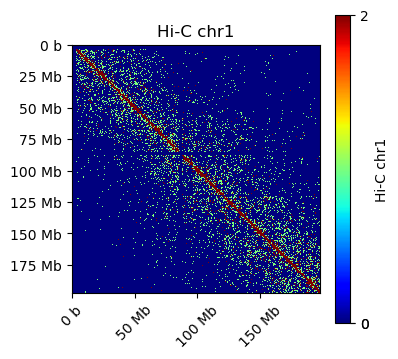

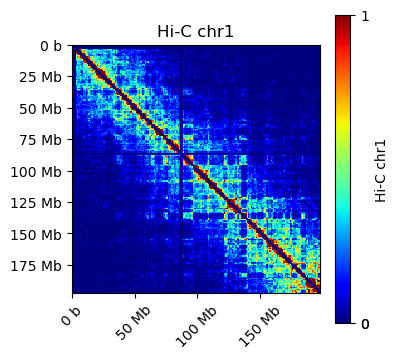

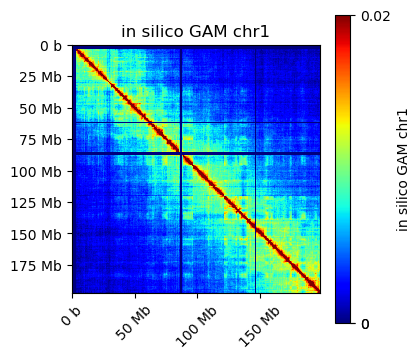

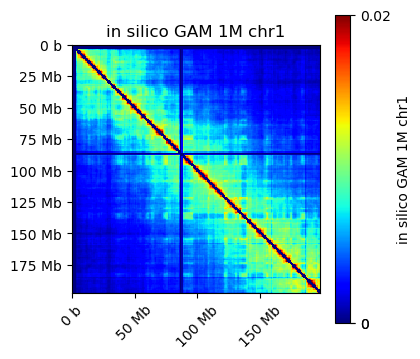

In [25]:
example_chr = "chr1"
start_pos = 0
end_pos = 197120000
hoxa_loc = f"{example_chr}:{start_pos}-{end_pos}"
start_pos_str = f"{start_pos//1000000}M"
end_pos_str = f"{end_pos//1000000}M"
start_idx = bin_table_df.query("chrom==@example_chr").reset_index().query("@start_pos >= start and @start_pos <= stop").index[0]
end_idx = bin_table_df.query("chrom==@example_chr").reset_index().query("@end_pos >= start and @end_pos <= stop").index[0]


plot_matrix(gam_dprime_list[example_chr],f"GAM  {example_chr}",start_pos,end_pos,"jet",0.4,0)
plot_matrix(gam_dprime_list_1m[example_chr],f"GAM 1M {example_chr}",start_pos,end_pos,"jet",0.3,-0.1)
plot_matrix(hic_list[example_chr],f"Hi-C {example_chr}",start_pos,end_pos,"jet",2,0)
plot_matrix(hic_list_1m[example_chr],f"Hi-C {example_chr}",start_pos,end_pos,"jet",1,0)
plot_matrix(silico_dprime_list[example_chr],f"in silico GAM {example_chr}",start_pos,end_pos,"jet",0.02,0)
plot_matrix(silico_dprime_list_1m[example_chr],f"in silico GAM 1M {example_chr}",start_pos,end_pos,"jet",0.02,0)

In [18]:
def logbinsnew(a, b, ratio=0, N=0):
    a = int(a)
    b = int(b)
    a10, b10 = np.log10([a, b])
    if ratio != 0:
        if N != 0:
            raise ValueError("Please specify N or ratio")
        N = int(np.log(b / a) / np.log(ratio))
    elif N == 0:
        raise ValueError("Please specify N or ratio")
    data10 = np.logspace(a10, b10, N)
    data10 = np.array(np.rint(data10), dtype=int)
    data10 = np.sort(np.unique(data10))
    assert data10[0] == a
    assert data10[-1] == b
    return data10
logbins = logbinsnew

def observedOverExpected(matrix):
    data = np.array(matrix, dtype=np.double, order='C')
    N = data.shape[0]
    
    # 假设 logbinsnew 是你在别处定义的函数
    _bins = logbinsnew(1, N, 1.03)
    _bins = [(0, 1)] + [(_bins[i], _bins[i+1]) for i in range(len(_bins) - 1)]
    bins = np.array(_bins, dtype=np.int64, order='C')
    
    for start, end in bins:
        ss = 0
        count = 0
        for offset in range(start, end):
            for j in range(N - offset):
                x = data[offset + j, j]
                if np.isnan(x):
                    continue
                ss += x
                count += 1

        if count > 0:
            meanss = ss / count
            if meanss != 0:
                for offset in range(start, end):
                    for j in range(N - offset):
                        data[offset + j, j] /= meanss
                        if offset > 0:
                            data[j, offset + j] /= meanss

    return data


def fillDiagonal(inArray, diag, offset=0):
    N = inArray.shape[0]
    assert inArray.shape[1] == N
    if offset >= 0:
        inArray.flat[offset:N * (N - offset):N + 1] = diag
    else:
        inArray.flat[(-offset * N)::N + 1] = diag


def removeDiagonals(inArray, m):
    for i in range(-m, m + 1):
        fillDiagonal(inArray, 0, i)

def remove_zeros(a):
    s = np.nansum(a, axis=0) > 0
    b = a[:, s]
    c = b[s, :]
    return c, s

def get_obs_over_exp(A):
    removeDiagonals(A, 1)
    #去掉nan
    A, mask = remove_zeros(A)
    
    M = len(A.flat)
    toclip = 100 * min(0.999, (M - 10.) / M)
    
    A = observedOverExpected(A)
    
    A = np.clip(A, -1e10, np.percentile(A, toclip))
    
    return A, mask


def PCA(A, numPCs=6, verbose=False):
    """performs PCA analysis, and returns 6 best principal components
    result[0] is the first PC, etc"""
    A = np.array(A, float)
    if np.sum(np.sum(A, axis=0) == 0) > 0 :
        warnings.warn("Columns with zero sum detected. Use zeroPCA instead")
    if np.sum(np.isnan(A)) > 0:
        raise ValueError("NaNs detected in input matrix!")
    M = (A - np.mean(A.T, axis=1)).T
    covM = np.dot(M, M.T)
    [latent, coeff] = scipy.sparse.linalg.eigsh(covM, numPCs)
    if verbose:
        print("Eigenvalues are:", latent)
    return (np.transpose(coeff[:, ::-1]), latent[::-1])

    
def do_PCA(A, n=3):
 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        A, mask = get_obs_over_exp(A)

    
    for i in [-1, 0, 1]:
        fillDiagonal(A, 1, i)

    
    A = np.corrcoef(A)
    PCs = PCA(A, n)[0]
    #一维数组           
    return PCs, mask
def replace_zeros_1d(a, s, value=np.NAN):
    new_a = np.ones_like(s, dtype=a.dtype) * value
    new_a[s] = a
    return new_a
def no_na(x, y):
    assert len(x) == len(y)
    return map(np.array, zip(*[ (x,y) for x,y in zip(x, y) if np.isfinite(x) and np.isfinite(y) ]))
def get_best_PC_index(pcs, mask, gc_content):
    
    pcs_out = []
    
    top_corr = 0
    top_index = 0
    
    for i, pc in enumerate(pcs):
                
        replaced_pc = replace_zeros_1d(pc, mask)
        
        corr_this_pc = pearsonr(*no_na(replaced_pc, gc_content))[0]
        
        if corr_this_pc < 0:
            replaced_pc = 0. - replaced_pc
            corr_this_pc = abs(corr_this_pc)
            
        pcs_out.append(replaced_pc)
        
        if corr_this_pc > top_corr:
            top_corr = corr_this_pc
            top_index = i
                        
    return top_index, pcs_out

## PCA

In [28]:
gc_content = gcdic[example_chr]
pc_gam, mask_gam = do_PCA(gam_dprime_list[example_chr], 3)
top_i_gam, pc_gam = get_best_PC_index(pc_gam, mask_gam, gc_content)

pc_hic, mask_hic= do_PCA(hic_list[example_chr], 3)
top_i_hic, pc_hic = get_best_PC_index(pc_hic, mask_hic, gc_content)

pc_silico, mask_silico= do_PCA(silico_dprime_list[example_chr], 3)
top_i_silico, pc_silico = get_best_PC_index(pc_silico, mask_silico, gc_content)

In [59]:
def plot_pc1_with_color_fill(pc1,start,end,data):
    x = np.arange(len(pc1))
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(x, pc1, label=data, color='none')  # 黑色线表示PC1

    # 大于0的部分用红色填充
    ax.fill_between(x, pc1, where=(pc1 > 0), color='#e35d43', alpha=1, interpolate=True)
    ax.fill_between(x, pc1, where=(pc1 < 0), color='#619cc8', alpha=1, interpolate=True)

    # 添加一些图表标签
    # ax.set_xlabel('Position')
    ax.set_ylabel('PC1 Value',fontsize=20)
    ax.spines['top'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(fontsize=15)

    tick_positions = [0, len(pc1)-1]  # 根据你的数据点分布调整这些值
    tick_labels = [start,end]
    plt.xticks(tick_positions, tick_labels)

    #设置xtick字体大小
    plt.xticks(fontsize=20)
    # 显示图形
    plt.show()

In [46]:
# 清洗数据，替换NaN和inf
pc_gam_clean = np.nan_to_num(pc_gam[0], nan=0.0)  # 将NaN替换为0
pc_hic_clean = np.nan_to_num(pc_hic[0], nan=0.0)  # 将NaN替换为0
pc_silico_clean = np.nan_to_num(pc_silico[0], nan=0.0)
# 确保没有inf
pc_gam_clean = np.clip(pc_gam_clean, -np.inf, np.inf)
pc_hic_clean = np.clip(pc_hic_clean, -np.inf, np.inf)
pc_silico_clean = np.clip(pc_silico_clean, -np.inf, np.inf)
pearson1 = pearsonr(pc_gam_clean,pc_hic_clean)[0]
pearson2 = pearsonr(pc_gam_clean,pc_silico_clean)[0]
print(pearson1)
print(pearson2)


0.23622136189342174
0.6609209424719721


Text(0.5, 1.0, 'Pearson correlation=0.66')

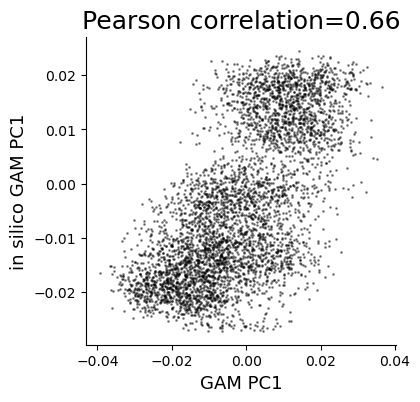

In [61]:
plt.figure(figsize=(4,4))
plt.scatter(pc_gam[0],pc_silico[0],s=1,c="black",alpha=0.4)
plt.xlabel("GAM PC1",fontsize=13)
plt.ylabel("in silico GAM PC1",fontsize=13)
#不显示上边框和有边框
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#设置字体大小
plt.title(f"Pearson correlation={np.round(pearson2,2)}",fontsize=18)


Text(0.5, 1.0, 'Pearson correlation=0.24')

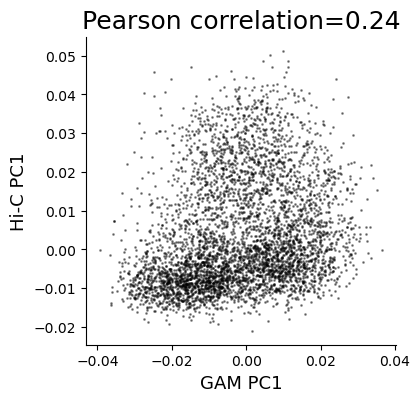

In [62]:
plt.figure(figsize=(4,4))
plt.scatter(pc_gam[0],pc_hic[0],s=1,c="black",alpha=0.4)
plt.xlabel("GAM PC1",fontsize=13)
plt.ylabel("Hi-C PC1",fontsize=13)
#不显示上边框和有边框
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#设置字体大小
plt.title(f"Pearson correlation={np.round(pearson1,2)}",fontsize=18)

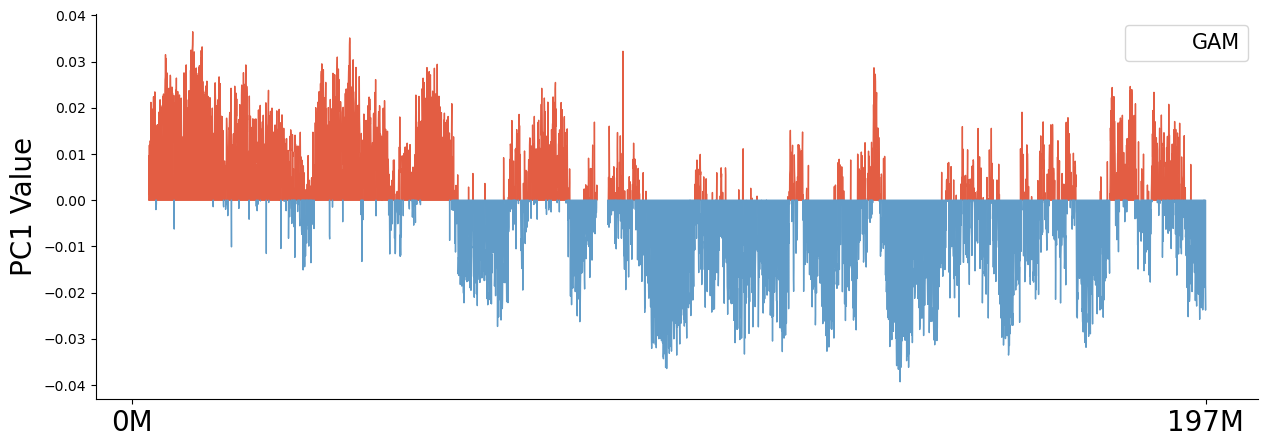

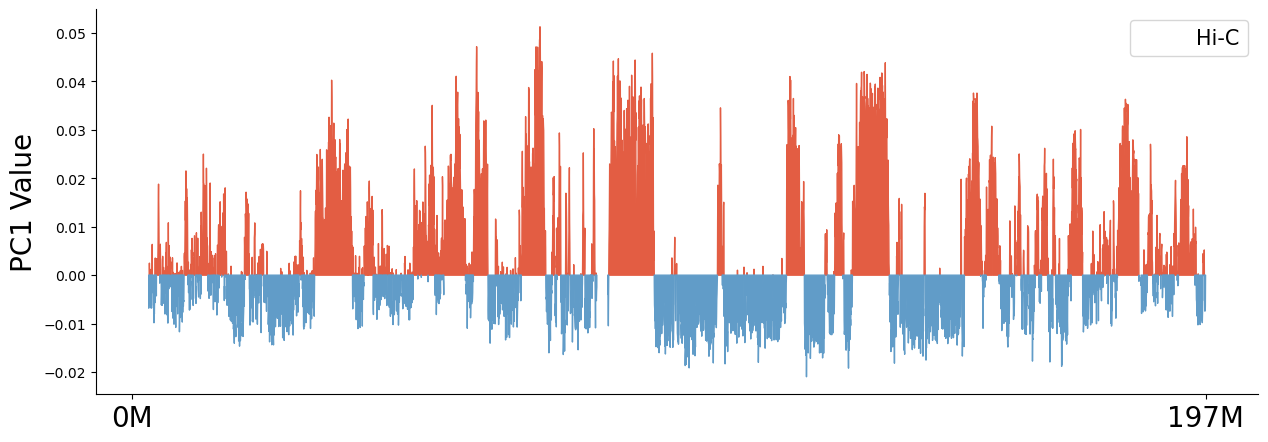

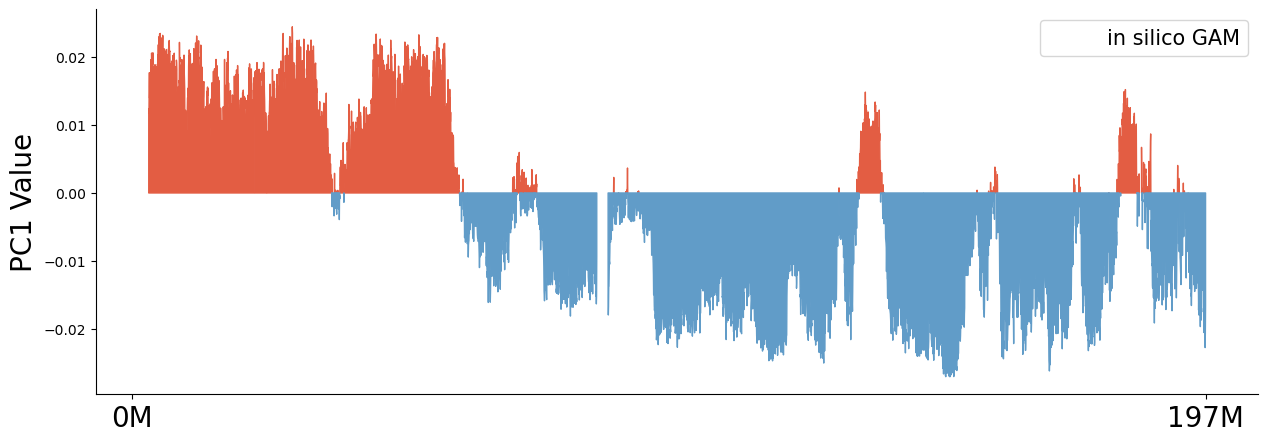

In [60]:
start = "0M"
end_length = df_mm.query("chrom==@example_chr")['size'].iat[0]//1000000
end = f'{end_length}M'
plot_pc1_with_color_fill(pc_gam[0],start,end,"GAM")
plot_pc1_with_color_fill(pc_hic[0],start,end,"Hi-C")
plot_pc1_with_color_fill(pc_silico[0],start,end,"in silico GAM")